# DM-31740: Check on DrpAssociate associator tolerance

DRP now includes running `DrpAssociationPipeTask` to associate DIA Sources into DIA Objects in one of its many steps. (This is basically a non-AP-flavored implementation of AP's `DiaPipe`.) The collection loaded here is tract 4431 of DC2; it was processed by Ken with w_2021_32 and analyzed in DM-30003.

Right now it the associator tolerance defaults to 0.5" for associating DIA Sources, but we have a truth table, so we can do some checks to see if this is reasonable or if another value would be more appropriate.

In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import pyarrow.parquet as pq
import functools
import operator

from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [2]:
repo = '/repo/dc2'
collection = 'u/kherner/2.2i/runs/test20210807-tract4431-w32-step5'
butler = dafButler.Butler(repo, collections=collection)

### Load DIA Sources into a pandas dataframe

I am sad there is no `butler.get('diaSourceTable')` with all the necessary info in it...

Specify just the columns we need when it's butler.get time so we don't asplode the memory.

In [3]:
dataIds =  butler.registry.queryDataIds(['band', 'instrument', 'detector', 'physical_filter', 'visit_system', 'visit'] , datasets="goodSeeingDiff_diaSrcTable", 
                                        collections=collection, where="instrument='LSSTCam-imSim' and tract=4431")

In [4]:
len([dataId for dataId in dataIds])

59605

In [5]:
# SLOW CELL IS SLOW
columnList = ['diaSourceId', 'ccdVisitId', 'filterName', 'midPointTai', 'flags', 'ra', 'decl', 'snr',
              'psFlux', 'psFluxErr']#, 'isDipole', 'totFlux', 'totFluxErr']
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId, parameters={"columns": columnList}))

df = pd.concat(tables)

In [6]:
df

,diaSourceId,ccdVisitId,filterName,midPointTai,flags,ra,decl,snr,psFlux,psFluxErr
0,1256277934080038,2340000,u,59583.123688,25165824,55.224051,-31.523492,0.287456,10393.564061,1349.301942
1,1256277934080039,2340000,u,59583.123688,25165824,55.253138,-31.524000,-1.465092,-1123.115523,217.827366
2,1256277934080040,2340000,u,59583.123688,25165824,55.216285,-31.533353,-1.335562,6441.603342,1853.469262
3,1256277934080041,2340000,u,59583.123688,0,55.107248,-31.567037,1.648211,1267.106493,248.008850
4,1256277934080042,2340000,u,59583.123688,0,55.188368,-31.562214,-0.629606,3287.332698,592.795526
...,...,...,...,...,...,...,...,...,...,...
60,660160196647059610,1229644188,i,61391.061261,796,55.544327,-32.600021,174.756798,245121.738292,1308.696596
61,660160196647059611,1229644188,i,61391.061261,796,55.566895,-32.487068,300.529467,196318.202493,702.755382
62,660160196647059612,1229644188,i,61391.061261,0,55.561919,-32.479717,-0.585181,1971.194424,400.825159
63,660160196647059613,1229644188,i,61391.061261,528,55.516161,-32.675950,15.756653,38783.229387,1465.138417


In [7]:
df.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'midPointTai', 'flags', 'ra',
       'decl', 'snr', 'psFlux', 'psFluxErr'],
      dtype='object')

In [8]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(df['flags'], 'flags')
flag_names = list(flag_values.dtype.names)

flags = pd.DataFrame(flag_values, index=df.index)
df = pd.concat([df, flags], axis=1)

In [9]:
instrumentDataId = butler.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
#df['visit'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
#df['detector'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])

In [10]:
# coordinates of all the DIA Sources
diaSourcesc = SkyCoord(df.ra, df.decl, unit='deg')

### Load truth table for tract 4431
Choose as few columns as necessary for memory purposes

In [11]:
truth_4431_path = '/project/shared/DC2/truth_parquet/truth_tract4431.parq'
truthCols = ['id', 'ra', 'dec', 'is_variable', 'is_pointsource', 'flux_g', 'flux_r']#, 'tract', 'patch']
truth_4431 = pq.read_pandas(truth_4431_path, columns=truthCols).to_pandas()

In [12]:
truth_4431

,id,ra,dec,is_variable,is_pointsource,flux_g,flux_r
0,5002139513,56.498354,-32.727155,0,0,126.404335,147.231842
1,5002508207,56.517981,-32.726763,0,0,24.991816,96.257736
2,5000205603,56.492242,-32.726853,0,0,32.223240,93.331459
3,5002154921,56.483952,-32.726708,0,0,445.314758,505.875549
4,5000066351,56.515231,-32.726446,0,0,150.253571,472.295349
...,...,...,...,...,...,...,...
4817456,5018695137,56.490380,-32.624497,0,0,12.969555,21.344536
4817457,5018696206,56.505265,-32.591326,0,0,7.714917,12.897940
4817458,5018697292,56.431988,-32.658800,0,0,2.990162,9.371014
4817459,5018697943,56.496915,-32.726105,0,0,5.927689,14.186604


In [13]:
truth_4431.columns

Index(['id', 'ra', 'dec', 'is_variable', 'is_pointsource', 'flux_g', 'flux_r'], dtype='object')

In [14]:
truthsc = SkyCoord(truth_4431.ra, truth_4431.dec, unit='deg')

### Crossmatch DIA Source coordinates with truth table coordinates

Then we can investigate how far away the matches are from the true source coordinates and decide if 0.5" is an appropriate `DrpAssociationPipeTask.associator.tolerance` for DP0.2

In [15]:
idx, d2d, d3d = diaSourcesc.match_to_catalog_sky(truthsc)

In [16]:
# Add crossmatch distances to the df that holds everything else
df['truth_xmatch_dist_arcsec'] = d2d.to_value(u.arcsecond)
df['truth_xmatch_id_all'] = pd.Series(truth_4431.iloc[idx]['id'].values, index=df.index)

In [17]:
nall = len(df)
nmatched10 = len(df.loc[df['truth_xmatch_dist_arcsec'] <= 1.0, 'truth_xmatch_id_all'])
nmatched05 = len(df.loc[df['truth_xmatch_dist_arcsec'] <= 0.5, 'truth_xmatch_id_all'])

In [18]:
print(nall, nmatched10, nmatched05)

2310652 1764925 1300600


In [19]:
df.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'midPointTai', 'flags', 'ra',
       'decl', 'snr', 'psFlux', 'psFluxErr', 'base_PixelFlags_flag',
       'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
       'base_PixelFlags_flag_interpolated', 'base_PixelFlags_flag_saturated',
       'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
       'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated', 'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels', 'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge', 'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad

In [20]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]
badFlags = [df[flag] for flag in badFlagList]
flagFilter = functools.reduce(operator.or_, badFlags)
noFlagFilter = ~flagFilter
goodSrc = df.loc[noFlagFilter]

<IPython.core.display.Javascript object>


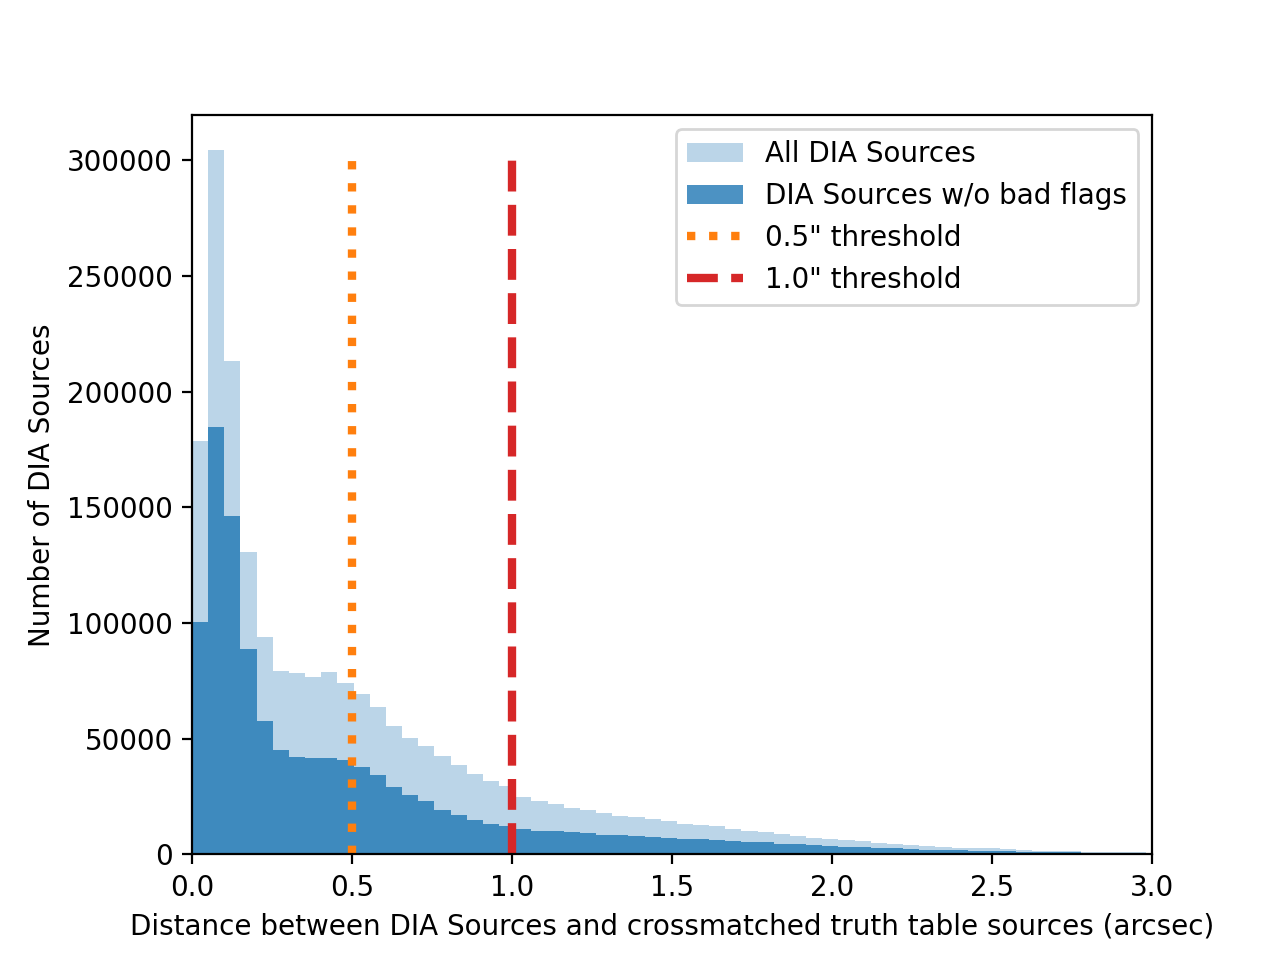

In [21]:
fig = plt.figure()
fig.subplots_adjust(left=0.15)
plt.hist(df['truth_xmatch_dist_arcsec'], bins=np.linspace(0,5,100), color='C0', alpha=0.3, label='All DIA Sources')
plt.hist(goodSrc['truth_xmatch_dist_arcsec'], bins=np.linspace(0,5,100), color='C0', alpha=0.8, label='DIA Sources w/o bad flags')
#plt.gca().set_yscale('log')
plt.gca().set_xlim(0, 3)
#plt.gca().set_ylim(0, 5e5)
plt.xlabel('Distance between DIA Sources and crossmatched truth table sources (arcsec)')
plt.ylabel('Number of DIA Sources')
plt.vlines(x=0.5, ymin=0, ymax=3e5, ls=':', lw=3, color='C1', label='0.5" threshold')
plt.vlines(x=1.0, ymin=0, ymax=3e5, ls='--', lw=3, color='C3', label='1.0" threshold')
plt.legend()

In [22]:
def analyze_matched_sources(df, truth, match_radius_arcsec):
    """Given a dataframe containing a bunch of diaSrcTables, a dataframe containing
    a truth table for sources in the same tract, and a match radius, analyze the matched sources.
    Remember non-variable truth sources shouldn't have valid matches to diaSrcTable sources.
    """
    # Add column truth_xmatch_XX_id that has the id for sources within XX arcsec and NaN otherwise
    colname = 'truch_xmatch_' + str(match_radius_arcsec) + '_id'
    df.loc[df['truth_xmatch_dist_arcsec'] <= match_radius_arcsec, colname] = df.loc[df['truth_xmatch_dist_arcsec'] <= match_radius_arcsec, 'truth_xmatch_id_all']
    dfm = pd.merge(truth, df, left_on='id', right_on=colname, how='outer')
    wmatched = (dfm['truth_xmatch_dist_arcsec'] <= match_radius_arcsec)
    
    # true positives
    wtp = wmatched & (dfm['is_variable'] == 1) # use explicit equality since is_variable can be NaN with no truth counterpart
    ntp = np.sum(wtp)
    dfm.loc[wtp,'confusion_label'] = 'True Positive'
    
    # true negatives 
    wtn = ~wmatched & (dfm['is_variable'] == 0)
    ntn = np.sum(wtn)
    dfm.loc[wtn,'confusion_label'] = 'True Negative'
    
    # false positives (either a match to a non-variable source, or a DIASource with no truth table counterpart)
    wfp = (wmatched & (dfm['is_variable'] == 0)) | (dfm['id'].isnull())
    nfp = np.sum(wfp)
    dfm.loc[wfp,'confusion_label'] = 'False Positive'
    
    # false negatives (maybe!  depends how bright the variability is) 
    wfn = ~wmatched & (dfm['is_variable'] == 1)
    nfn = np.sum(wfn)
    dfm.loc[wfn,'confusion_label'] = 'False Negative'
    
    # plot a confusion matrix and flavor of matched source vs flux
    y_true = dfm['is_variable'] == 1.0
    y_pred = wmatched
    cm = confusion_matrix(y_true, y_pred, normalize='true')#, labels=clf.classes_)
    completeness = cm[1,1]/np.sum(cm[1,:])
    purity = cm[1,1]/np.sum(cm[:,1])

    #fig1 = plt.figure(figsize=(8,8))
    #ax1 = fig1.add_subplot(111)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=clf.classes_)
    disp.plot()
    
    fig2 = plt.figure(figsize=(8,6))
    bins = np.logspace(1,9,100)
    _ = plt.hist(dfm.loc[wtp,'flux_r'], bins=bins, label='TP', histtype='step')
    _ = plt.hist(dfm.loc[wfp,'flux_r'], bins=bins, label='FP', histtype='step')
    _ = plt.hist(dfm.loc[wtn,'flux_r'], bins=bins, label='TN', histtype='step')
    _ = plt.hist(dfm.loc[wfn,'flux_r'], bins=bins, label='FN', histtype='step')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R-band flux (nJy)')
    plt.ylabel('Number of Sources')
    
    fig = plt.figure()
    fig.subplots_adjust(left=0.15)
    
    # I wanted to plot with/without bad flags, but this kept pushing me over the kernel death memory limit
    #badFlagList = ['base_PixelFlags_flag_bad',
    #           'base_PixelFlags_flag_suspect',
    #           'base_PixelFlags_flag_saturatedCenter',
    #           'base_PixelFlags_flag_interpolated',
    #           'base_PixelFlags_flag_interpolatedCenter',
    #           'base_PixelFlags_flag_edge',
    #          ]
    #badFlags = [dfm[flag] for flag in badFlagList]
    #flagFilter = functools.reduce(operator.or_, badFlags)
    #noFlagFilter = ~flagFilter
    #goodSrcDfm = dfm.loc[noFlagFilter]
        
    plt.hist(dfm.loc[dfm['is_variable'] == 1, 'truth_xmatch_dist_arcsec'],
             bins=np.linspace(0,5,100), color='C0', alpha=0.3, label='All variable-matched DIA Sources')
    plt.hist(dfm.loc[(dfm['snr'] > 5) & (dfm['is_variable'] == 1), 'truth_xmatch_dist_arcsec'],
             bins=np.linspace(0,5,100), color='C0', alpha=0.8, label='Only those with SNR > 5')

    plt.gca().set_xlim(0, 3)
    plt.xlabel('Distance between DIA Sources and crossmatched truth table sources (arcsec)')
    plt.ylabel('Number of DIA Sources')
    plt.vlines(x=0.5, ymin=0, ymax=3e5, ls=':', lw=3, color='C1', label='0.5" threshold')
    plt.vlines(x=1.0, ymin=0, ymax=3e5, ls='--', lw=3, color='C3', label='1.0" threshold')
    plt.legend()

<IPython.core.display.Javascript object>


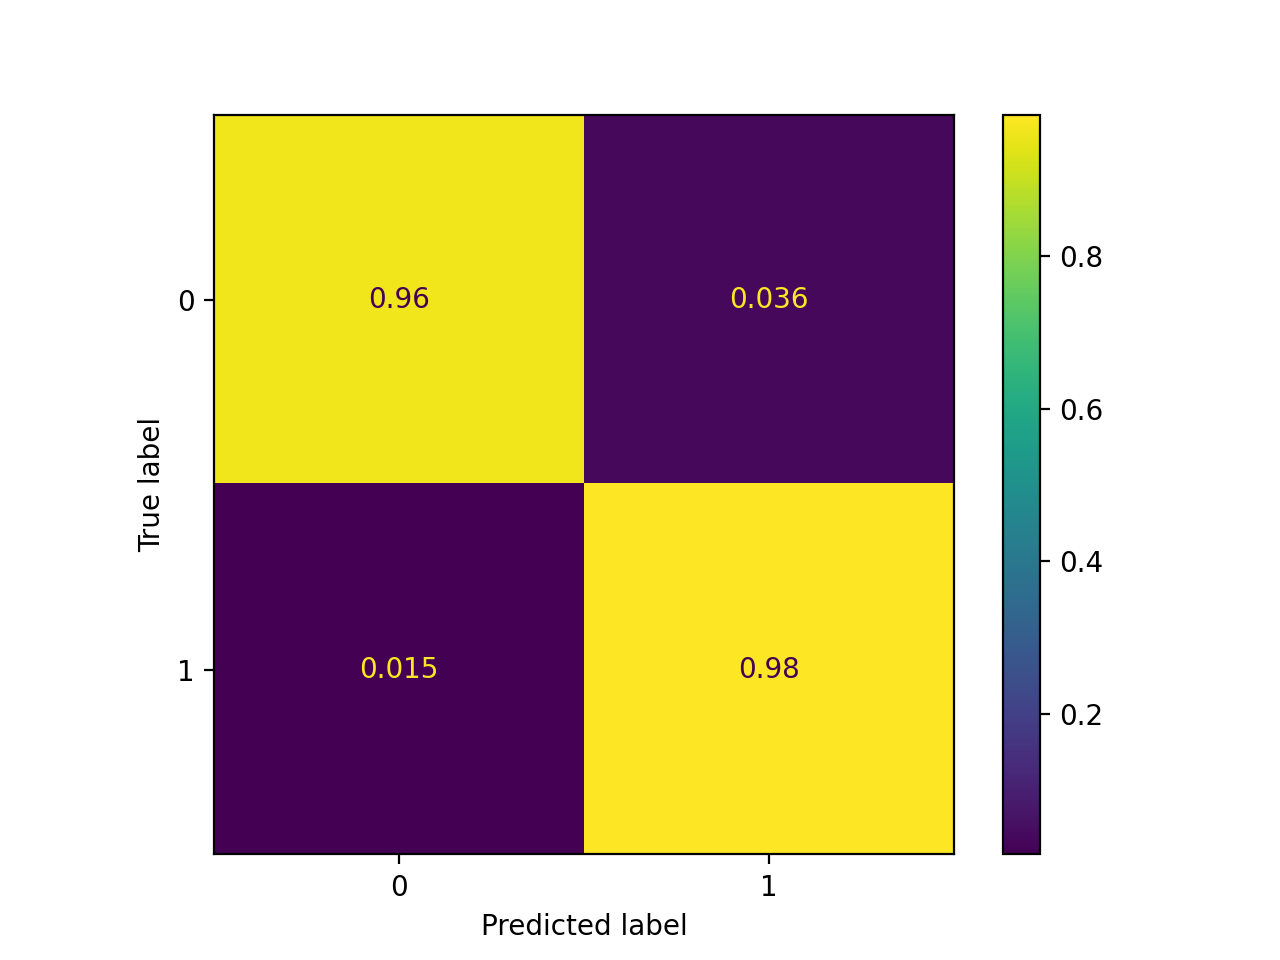

<IPython.core.display.Javascript object>


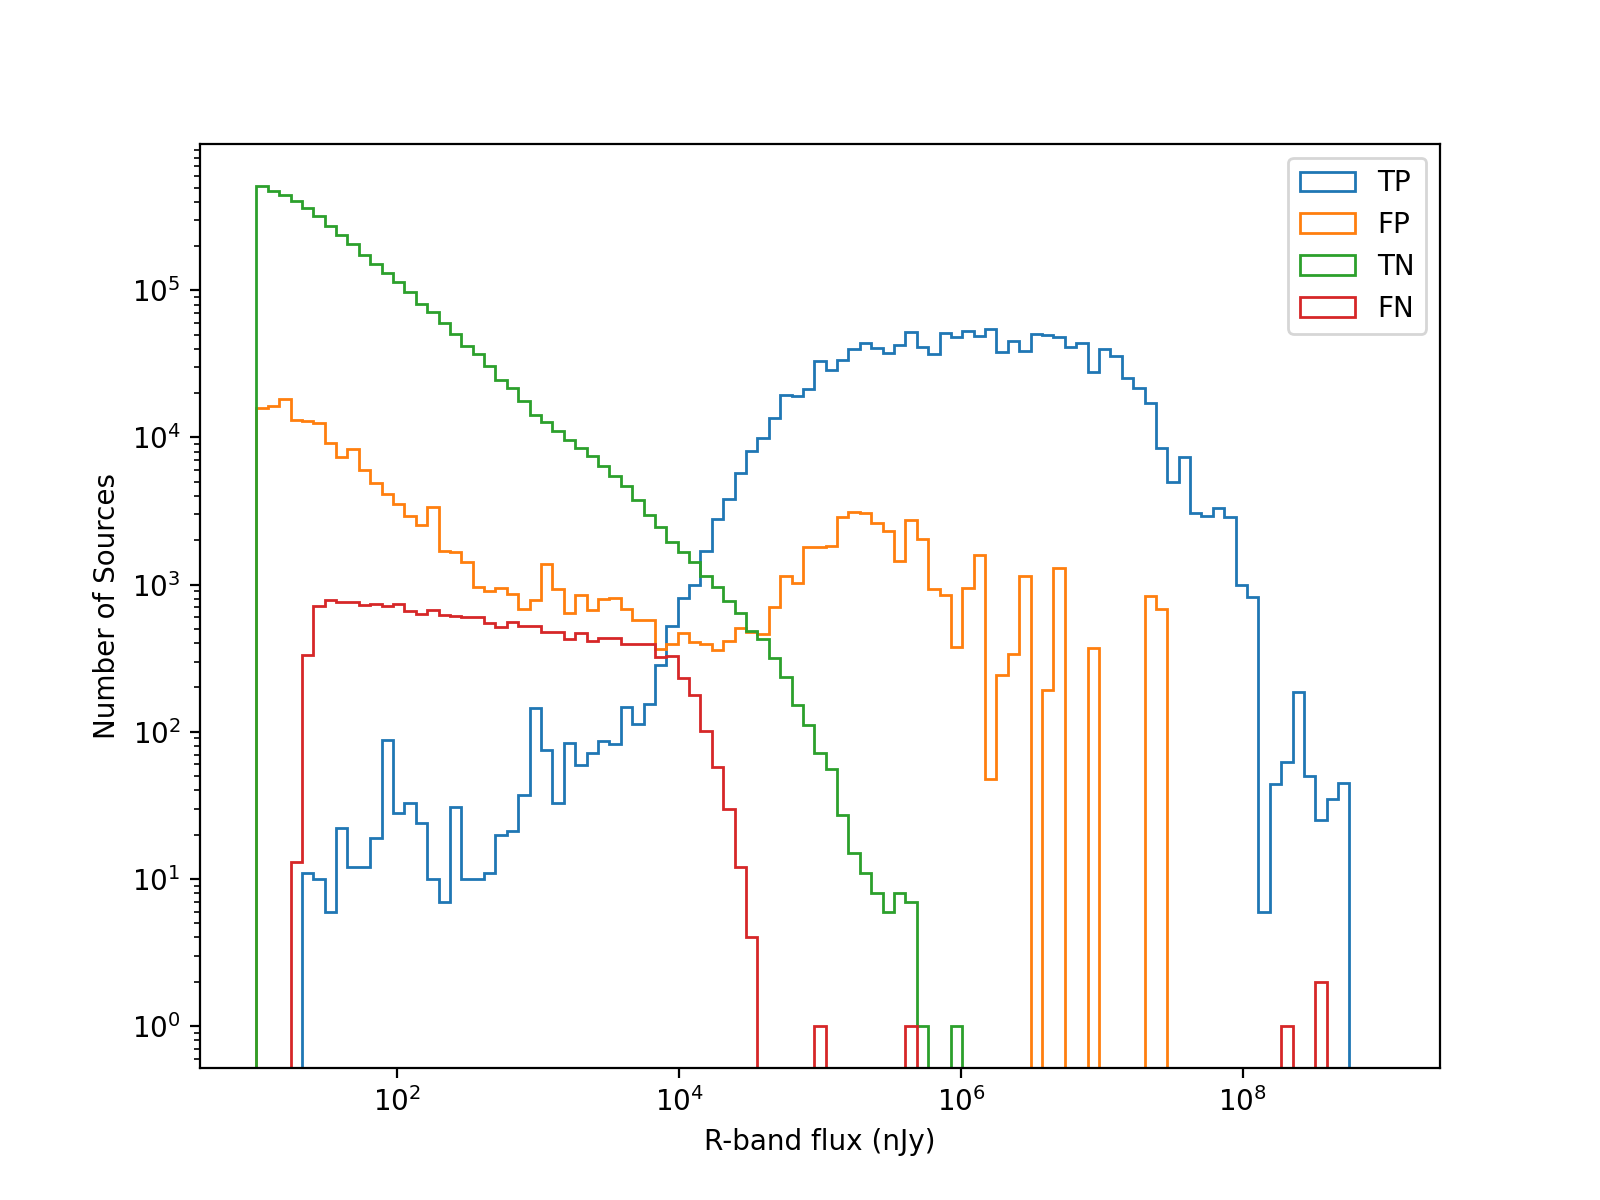

<IPython.core.display.Javascript object>


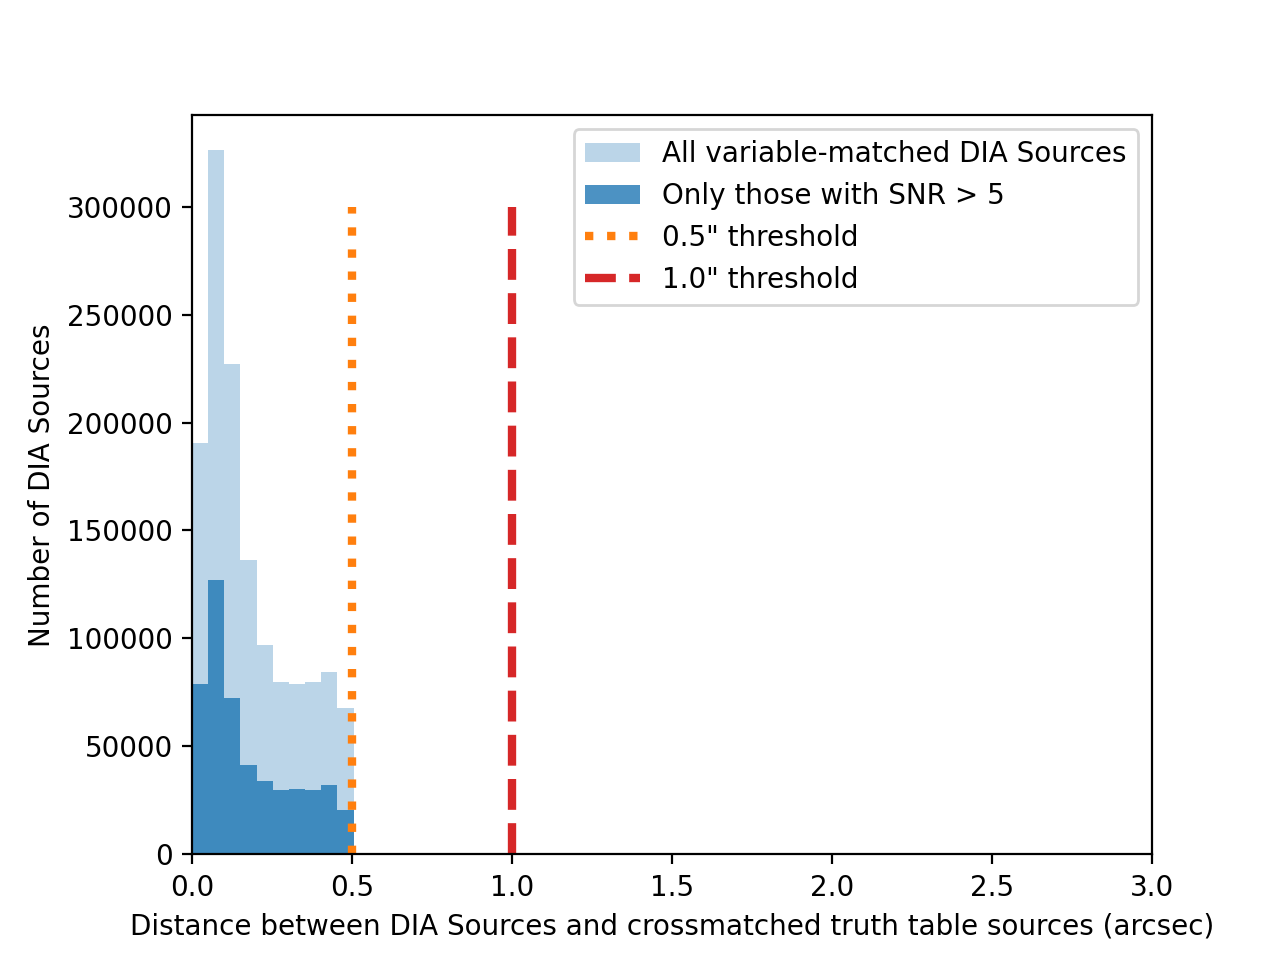

In [23]:
analyze_matched_sources(df, truth_4431, match_radius_arcsec=0.5)

<IPython.core.display.Javascript object>


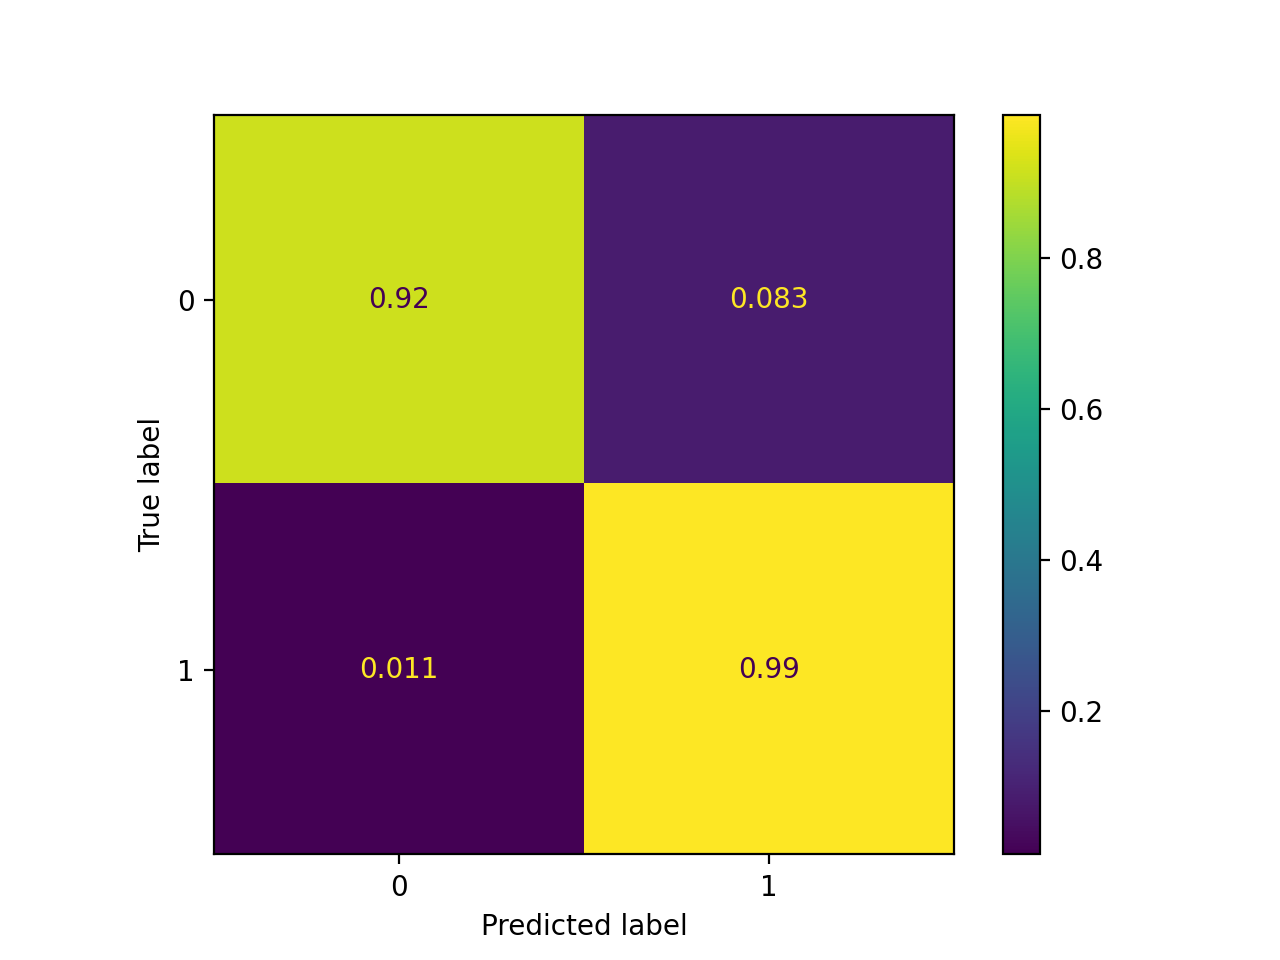

<IPython.core.display.Javascript object>


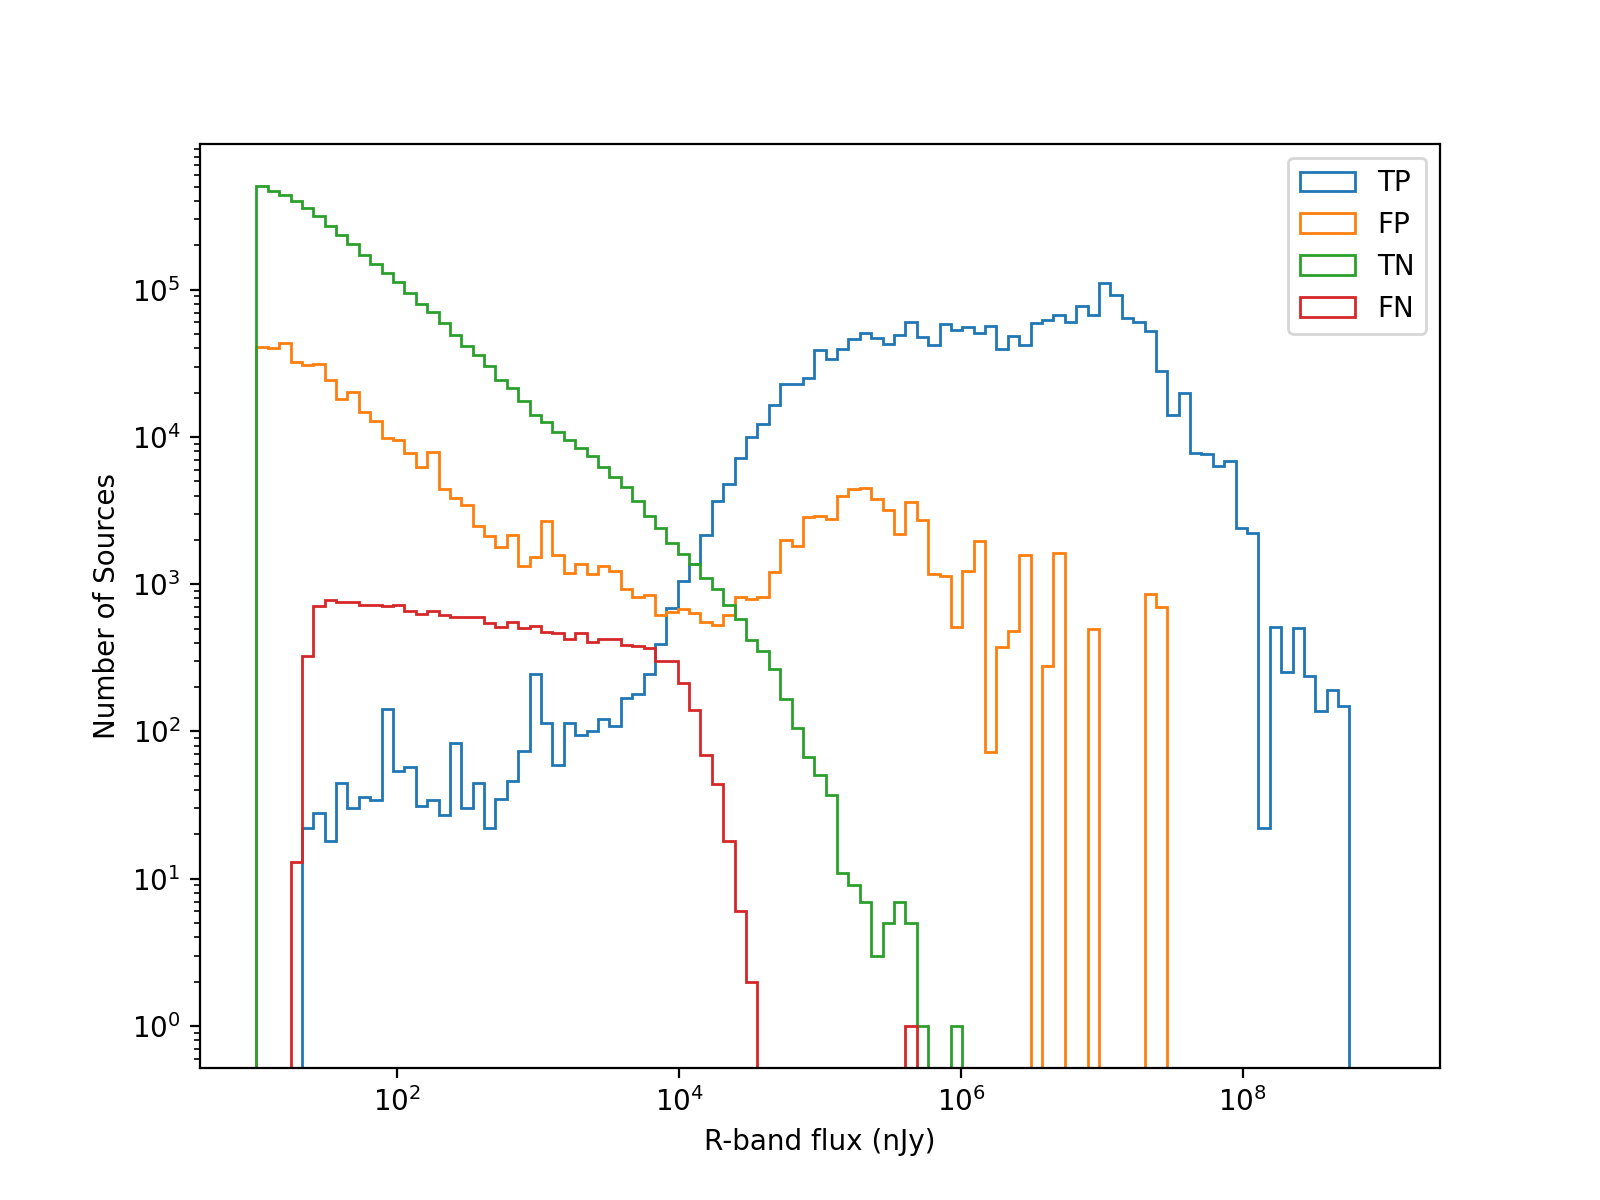

<IPython.core.display.Javascript object>


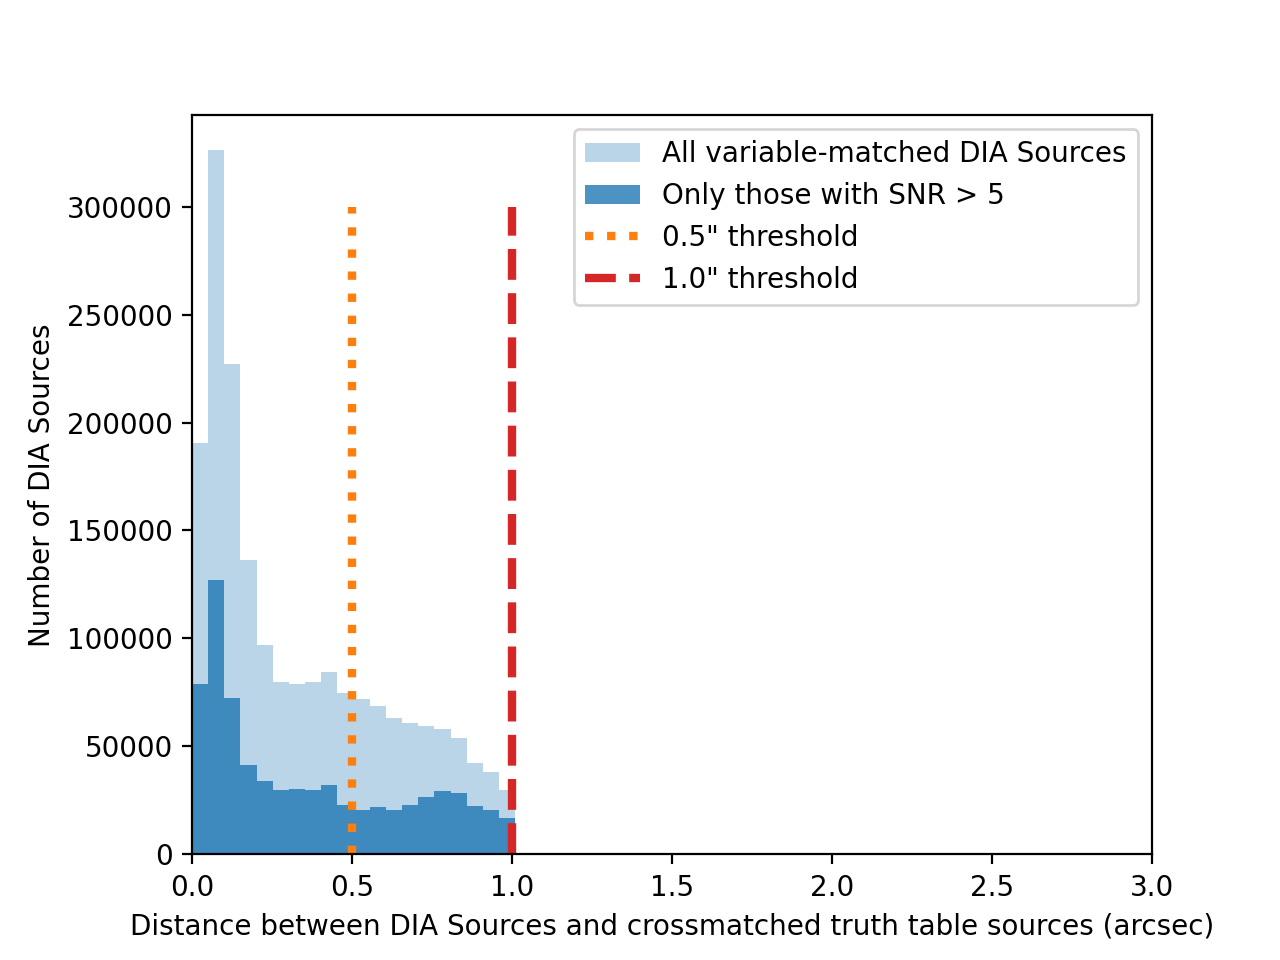

In [24]:
analyze_matched_sources(df, truth_4431, match_radius_arcsec=1.0)